In [125]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm.models
from ddm import Sample
from itertools import product
from IPython.display import display
from ddm import Model, Fittable
from ddm.functions import fit_adjust_model, display_model
from ddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
import ddm.plot
from copy import deepcopy

## Load and Clean Data
We exlcude
1. Trials with coherence over 0.2
2. Trials with rt under 0.1
3. Trials with invalid rt

In [158]:
# Read Data
columns =['subject', 'noise_color', 'trial', 'noise_trial', 'session', 'coherence', 'correct', 'rt']
data = pd.read_csv('allData.txt', header = None, names=columns)
data['subject'] = [sub.split('_')[2][-6:] for sub in data['subject']]

# Choose only Subject with real Stimulation 
data = data.loc[(data['noise_color']=='white') | (data['noise_color']=='pink') | (data['noise_color']=='blue')]

# Exclude Trials with invalid Reaction Time and reaction times lower than 0.1
data = data[~data['rt'].isnull()]
print('All Valid: ', ~np.any(data.isnull()))
data = data[(data['rt']>0.1) & data['rt']<2.0]

# Exlude Trials with Coherence Levels higher than 200 and reset coherence to percent
data = data[data['coherence']<=200]
data['coherence'] /= 1000

# Round Reaction Times 
data['rt'] = np.round(data['rt'],3)

# Get Subject List
SubjectList = np.unique(data['subject'])
print('Subjects: ', SubjectList)
display(data)

All Valid:  True
Subjects:  ['LAB001' 'LAB002' 'LAB004' 'LAB006' 'LAB008' 'LAB011' 'LAB014']


,subject,noise_color,trial,noise_trial,session,coherence,correct,rt
4,LAB001,white,5,5,1,0.200,1,0.583
5,LAB001,white,6,6,1,0.100,1,0.983
6,LAB001,white,7,7,1,0.050,1,1.166
7,LAB001,white,8,8,1,0.025,0,1.216
8,LAB001,white,9,9,1,0.025,0,0.600
...,...,...,...,...,...,...,...,...
46151,LAB014,blue,916,240,4,0.015,1,1.116
46152,LAB014,blue,917,241,4,0.023,0,1.550
46153,LAB014,blue,918,242,4,0.028,0,1.366
46154,LAB014,blue,919,243,4,0.045,1,1.283


## Single Subject Example
## Load Data into pyddm

In [159]:
# Subject Lab001 dfs with different Noise colors
white_df = data.loc[(data['noise_color']=='white')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
white_sample = Sample.from_pandas_dataframe(white_df, rt_column_name="rt", correct_column_name="correct")

blue_df = data.loc[(data['noise_color']=='blue')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
blue_sample = Sample.from_pandas_dataframe(blue_df, rt_column_name="rt", correct_column_name="correct")

pink_df = data.loc[(data['noise_color']=='pink')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
pink_sample = Sample.from_pandas_dataframe(pink_df, rt_column_name="rt", correct_column_name="correct")

print('Example Sample - White Noise')
display(white_df)

Example Sample - White Noise


,correct,rt,coherence
4,1,0.583,0.200
5,1,0.983,0.100
6,1,1.166,0.050
7,0,1.216,0.025
8,0,0.600,0.025
...,...,...,...
33970,1,1.466,0.033
33971,0,1.983,0.017
33973,0,1.733,0.017
33975,0,1.549,0.025


## Plot Correct Response vs. Reaction Time - White Noise

Text(0.5, 1.0, 'False Trials')

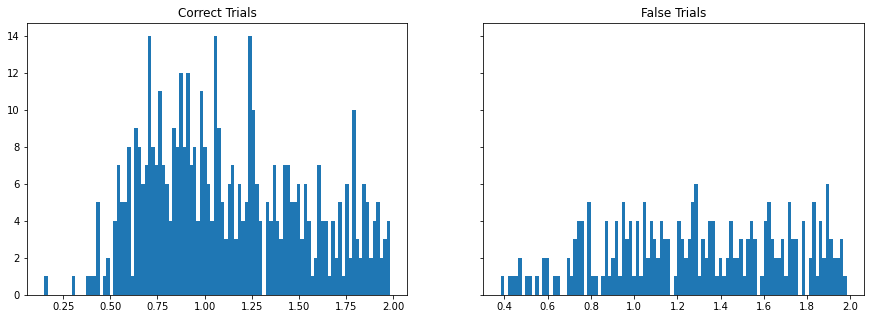

In [172]:
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
correct_white = white_df[white_df['correct']==1]
ax[0].hist(correct_white['rt'], bins=100);
ax[0].set_title('Correct Trials')
false_white = white_df[white_df['correct']==0]
ax[1].hist(false_white['rt'], bins=100);
ax[1].set_title('False Trials')

## Set up Drift Diffusion Model

In [163]:
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    # Parameter that should be included in the ddm
    required_parameters = ["driftcoherence"] 
    # Task Parameter, i.e. coherence
    required_conditions = ["coherence"] 
    
    # Define the get_drift function
    def get_drift(self, conditions, **kwargs):
        return self.driftcoherence * conditions['coherence']

# Set up Model with Drift depending on Coherence
model = Model(name='Noise Model - Drift varies with coherence',
             drift=DriftCoherence(driftcoherence=Fittable(minval=0, maxval=20)),
             noise=NoiseConstant(noise=1),
             bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
             overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                            OverlayPoissonMixture(pmixturecoef=.02,
                                                                  rate=1)]),
            dx=.01, dt=.01, T_dur=2)

## Fit Model

In [164]:
fit_adjust_model(sample=white_sample, model=model, verbose=False)
white_fit = deepcopy(model)
fit_model_blue = fit_adjust_model(sample=blue_sample, model=model, verbose=False)
blue_fit = deepcopy(model)
fit_model_pink = fit_adjust_model(sample=pink_sample, model=model, verbose=False)
pink_fit = deepcopy(model)

differential_evolution step 1: f(x)= 880.548
differential_evolution step 2: f(x)= 866.184
differential_evolution step 3: f(x)= 866.184
differential_evolution step 4: f(x)= 865.75
differential_evolution step 5: f(x)= 865.334
differential_evolution step 6: f(x)= 864.404
Params [11.49189572  0.99544532  0.35438265] gave 864.2445850390436
differential_evolution step 1: f(x)= 961.622
differential_evolution step 2: f(x)= 956.949
differential_evolution step 3: f(x)= 956.949
differential_evolution step 4: f(x)= 945.386
differential_evolution step 5: f(x)= 944.694
differential_evolution step 6: f(x)= 944.694
differential_evolution step 7: f(x)= 944.221
Params [13.75011142  0.95661382  0.34715074] gave 944.1537211756679
differential_evolution step 1: f(x)= 988.319
differential_evolution step 2: f(x)= 981.057
differential_evolution step 3: f(x)= 981.057
differential_evolution step 4: f(x)= 974.815
differential_evolution step 5: f(x)= 974.815
differential_evolution step 6: f(x)= 974.372
differenti

## Plot Model Fits

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 11.491896
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.995445
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.354383
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 864.2445850390436
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

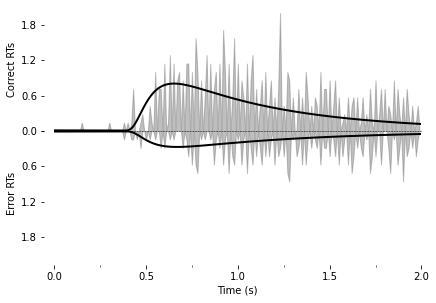

In [166]:
display_model(white_fit)
ddm.plot.plot_fit_diagnostics(model=white_fit, sample=white_sample)

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 13.750111
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.956614
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.347151
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 944.1537211756679
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

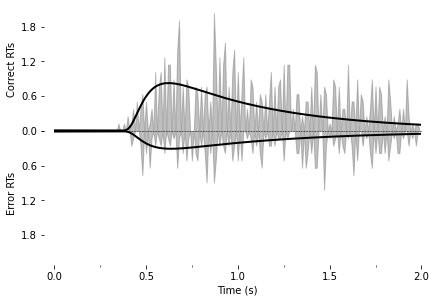

In [167]:
display_model(blue_fit)
ddm.plot.plot_fit_diagnostics(model=blue_fit, sample=blue_sample)

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 13.662490
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.947642
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.336926
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 974.3636716293719
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

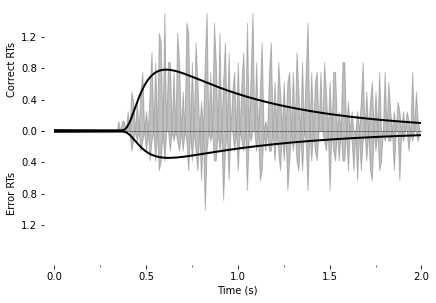

In [168]:
display_model(pink_fit)
ddm.plot.plot_fit_diagnostics(model=pink_fit, sample=pink_sample)